# STR Adaptativo Directo

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import scipy as sc
import math
import sympy as sp

## Planta a controlar y especificaciones

Obtener un controlador STR para el sistema de primer orden descripto por la transferencia

$$G(s)=\frac{1}{s(s+1)}$$

Se desea seguimiento a un modelo de segundo orden de frecuencia=1 rad/s, coeficiente de amortiguamiento 0.7, y ganancia de continua unitaria 
Considerar Ts=0.5s

In [2]:
# Especificación del modelo
# parámetros
wn = 1.0         # rad/s (natural frequency)
zeta = 0.7       # damping
Ts = 0.5         # periodo de muestreo

# Motor. Sistema continuo
s = ctrl.TransferFunction.s
K = 1.0
tau = 1.0
G = K / s / (tau * s + 1)

# Discretización
Gd = ctrl.c2d(G, Ts, method='zoh')
Gd.name = 'Planta'
print(f'Sistema discretizado: {Gd}')

# polos continuos
p1 = -zeta*wn + 1j*wn*math.sqrt(1 - zeta**2)
p2 = -zeta*wn - 1j*wn*math.sqrt(1 - zeta**2)

# polos discretos (mapeo exacto s -> z)
z1 = np.exp(p1 * Ts)
z2 = np.exp(p2 * Ts)

# Armo el modelo a seguir
Am = np.poly([z1, z2])              
Bm = np.polymul([1,0],[np.sum(Am)])

# Selección del modelo a seguir: tiene d0=1 (igual a la planta) y pide cancelar un cero de la planta de los que no es bueno andar cancelando
#Bm = [0.1761, 0]
#Am = [1, -1.3205, 0.4966]
Gm = ctrl.TransferFunction(Bm,Am,dt=Ts)
Gm.name='Modelo'
print(f'Ganancia de continua = {np.sum(Bm)/np.sum(Am)}')
print('Modelo a seguir',Gm)

Sistema discretizado: <TransferFunction>: Planta
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

    0.1065 z + 0.0902
  ----------------------
  z^2 - 1.607 z + 0.6065
Ganancia de continua = 1.0
Modelo a seguir <TransferFunction>: Modelo
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

        0.1761 z
  ---------------------
  z^2 - 1.32 z + 0.4966


## Implementación del STR adaptativo directo con cancelación de ceros 


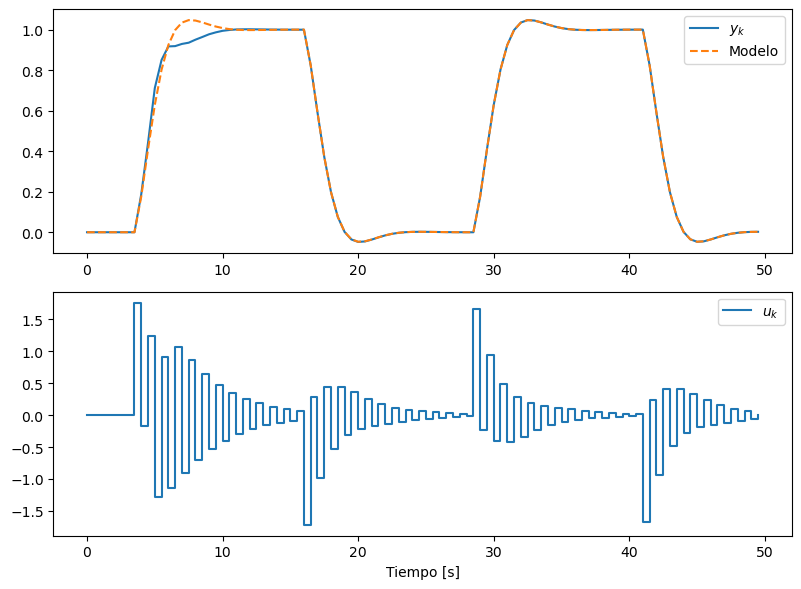

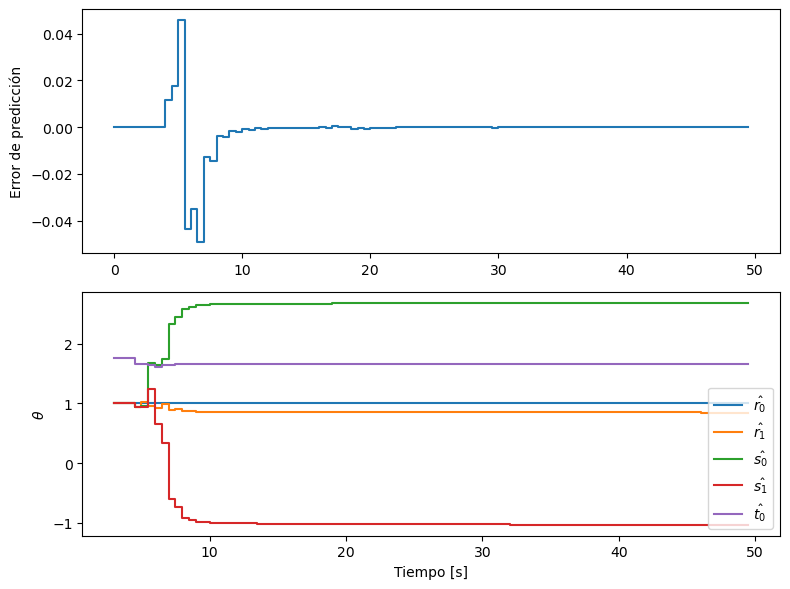

In [49]:
def simular_STR_directo(G,Gm,t_final,Ts=0.5,sigma_v=0.1,theta_real=None):
    # --- Simulación ---
    t = np.arange(0, t_final, Ts)
    n_steps = len(t)

    # Señales
    np.random.seed(0)
    r = 0.5 * (sc.signal.square(2*np.pi * t / 25 - np.pi/4) + 1)  # de 0 a 1
    v = sigma_v*np.random.randn(n_steps)
    #v = sigma_v*np.ones(n_steps)
    y = np.zeros(n_steps)
    yf = np.zeros_like(y)
    y_hat = np.zeros_like(y)
    err = np.zeros_like(y)
    u = np.zeros_like(y)
    uf = np.zeros_like(y)
    param_hist = []    

    # Parámetros de la identificación
    lambda_ = 0.95
    d0 = 1

    # Especificación de la estructura del controlador
    nr = 2
    ns = 2
    # Especificación del comportamiento a lazo cerrado
    Alc_bar = [1,0]
    Am = np.array(Gm.den[0]).flatten()
    Af = np.polymul(Alc_bar,Am)

    # Inicialización del estimador
    theta_hat = np.ones(nr+ns)/10
    P = 100 * np.eye(nr+ns)          # matriz de incertidumbre grande

    # Estado continuo
    Gss = ctrl.tf2ss(G)
    x = np.zeros(Gss.A.shape[0])
    for k in range(5, n_steps-1):
        # Nota memoria: y[k] = salida actual   u[k] entrada actual

        # Calculo las señales filtradas yf, uf
        yf[k] = -np.array(Af[1:]) @ np.array(yf[k-1:k-len(Af):-1]) + y[k-d0]
        uf[k] = -np.array(Af[1:]) @ np.array(uf[k-1:k-len(Af):-1]) + u[k-d0]

        # Armo el regresor
        phi = np.concatenate((uf[k:k-nr:-1], yf[k:k-ns:-1]))   # vector de regresores

        # Calculo y estimado y el error de estimación
        y_hat[k] = phi @ theta_hat
        err[k] = y[k] - y_hat[k]

        # Actualizo la estimación de parámetros
        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        # Calculo los polinomios del controlador
        R_tilde = theta_hat[0:nr]
        S_tilde = theta_hat[nr:nr+ns]

        R = R_tilde/R_tilde[0]
        S = S_tilde/R_tilde[0]
        T = [np.sum(Alc_bar)*np.sum(Am)/R_tilde[0]]

        # Almaceno los parámetros estimados para graficar luego
        param = theta_hat.copy()
        param /= param[0]
        param = np.append(param.flatten(), T[0]) 
        param_hist.append(param)

        # Calcular u[k] según controlador discreto:
        # R(q)u = T(q)r - S(q)y
        # => u[k] = (1/R0) * ( ... )
        # Calculo la acción de control del STR
        u[k] = (np.dot(T,r[k:k-len(T):-1]) 
                - np.dot(S, y[k:k-len(S):-1]) 
                - np.dot(R[1:], u[k-1:k-len(R):-1]))/R[0] 
        
        # Simular dinámica continua con entrada u[k]
        # Equivale a usar un ZOH
        resp = ctrl.forced_response(Gss, [t[k-1], t[k]], U=u[k]+v[k], X0=x,return_states=True)
        x = resp.states[:,-1]
        y[k+1] = resp.y[:,-1].item()  # tomar valor al final del período

    param_hist = np.array(param_hist)

    # Para comparar con el modelo
    t_m,y_m = ctrl.forced_response(Gm,t,U=r)

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(t,y,label='$y_k$')
    plt.plot(t_m,y_m,'--',label='Modelo')
    plt.legend()
    plt.subplot(2,1,2)
    plt.step(t,u,where='post',label='$u_k$')
    plt.xlabel('Tiempo [s]')
    plt.tight_layout()
    plt.legend()

    plt.figure(figsize=(8,6))
    plt.subplot(211)        
    plt.step(t,err,where='post')
    plt.ylabel('Error de predicción')
    plt.subplot(212)

    for idx_nr in range(0,nr):        
        plt.step(t[-len(param_hist):],param_hist[:,idx_nr], label=f"$\\hat{{r_{idx_nr}}}$",where='post')
    for idx_ns in range(0,ns):
        plt.step(t[-len(param_hist):],param_hist[:,nr+idx_ns], label=f"$\\hat{{s_{idx_ns}}}$",where='post')
    plt.step(t[-len(param_hist):],param_hist[:,nr+ns], label=f"$\\hat{{t_0}}$",where='post')

    plt.legend()
    plt.xlabel('Tiempo [s]')
    plt.ylabel('$\\theta$')
    plt.tight_layout()    
    plt.show()


simular_STR_directo(G,Gm,50,Ts,sigma_v=0)